In [301]:
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error as mae
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [302]:
path = 'https://raw.githubusercontent.com/dataworkshop/5dwchallenge_2019/master/challenge5/input/mauna_loa.csv'

df = pd.read_csv(path)

df.head()

,year,month,day,decimal,ppm,#days,1 yr ago,10 yr ago,since 1800
0,1974,5,19,1974.3795,333.34,6,-999.99,-999.99,50.36
1,1974,5,26,1974.3986,332.95,6,-999.99,-999.99,50.06
2,1974,6,2,1974.4178,332.32,5,-999.99,-999.99,49.57
3,1974,6,9,1974.4370,332.18,7,-999.99,-999.99,49.63
4,1974,6,16,1974.4562,332.37,7,-999.99,-999.99,50.07


In [303]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.head()

,year,month,day,decimal,ppm,#days,1 yr ago,10 yr ago,since 1800,date
0,1974,5,19,1974.3795,333.34,6,-999.99,-999.99,50.36,1974-05-19
1,1974,5,26,1974.3986,332.95,6,-999.99,-999.99,50.06,1974-05-26
2,1974,6,2,1974.4178,332.32,5,-999.99,-999.99,49.57,1974-06-02
3,1974,6,9,1974.4370,332.18,7,-999.99,-999.99,49.63,1974-06-09
4,1974,6,16,1974.4562,332.37,7,-999.99,-999.99,50.07,1974-06-16


In [304]:
df['ppm_fixed'] = df['ppm'].map(lambda x: np.nan if x < 0 else x)

df['ppm_fixed'].fillna(method='backfill', inplace=True)

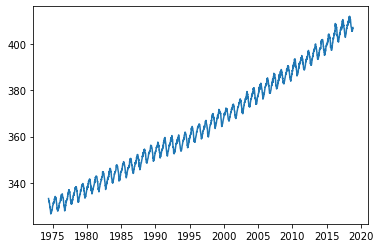

In [305]:
plt.plot(df.date, df.ppm_fixed);

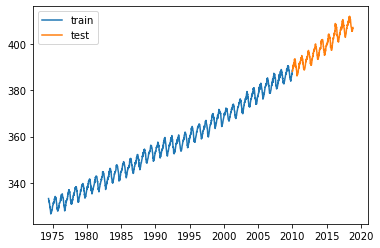

In [306]:
#cut_year = 2017
cut_year = 2010

train = df[df.year < cut_year]
test = df[df.year >= cut_year]

plt.plot(train.date, train.ppm_fixed, label='train');
plt.plot(test.date, test.ppm_fixed, label='test');
plt.legend();

## Prophet

In [307]:
fb_df = train[['date', 'ppm_fixed']].copy()
fb_df.columns = ['ds', 'y']
fb_df.head()

,ds,y
0,1974-05-19,333.34
1,1974-05-26,332.95
2,1974-06-02,332.32
3,1974-06-09,332.18
4,1974-06-16,332.37


In [308]:
model = Prophet()
model.fit(fb_df);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [309]:
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model.fit(fb_df);

In [310]:
future = model.make_future_dataframe(periods=len(test), freq='W', include_history=False)
future.tail()

,ds
457,2018-10-07
458,2018-10-14
459,2018-10-21
460,2018-10-28
461,2018-11-04


In [311]:
test.tail()

,year,month,day,decimal,ppm,#days,1 yr ago,10 yr ago,since 1800,date,ppm_fixed
2316,2018,10,7,2018.7658,405.58,7,403.38,382.78,129.25,2018-10-07,405.58
2317,2018,10,14,2018.7849,406.00,6,403.81,382.92,129.45,2018-10-14,406.00
2318,2018,10,21,2018.8041,406.62,7,404.04,383.04,129.77,2018-10-21,406.62
2319,2018,10,28,2018.8233,406.48,6,404.07,383.96,129.29,2018-10-28,406.48
2320,2018,11,4,2018.8425,406.99,5,404.26,383.80,129.43,2018-11-04,406.99


In [312]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-03,388.551361,385.761033,391.367964,388.551361,388.551361,0.0,0.0,0.0,0.0,0.0,0.0,388.551361
1,2010-01-10,388.589462,385.816273,391.368462,388.589462,388.589462,0.0,0.0,0.0,0.0,0.0,0.0,388.589462
2,2010-01-17,388.627563,385.681305,391.249129,388.627563,388.627563,0.0,0.0,0.0,0.0,0.0,0.0,388.627563
3,2010-01-24,388.665664,386.074214,391.400647,388.665664,388.665664,0.0,0.0,0.0,0.0,0.0,0.0,388.665664
4,2010-01-31,388.703765,385.917964,391.510033,388.703765,388.703765,0.0,0.0,0.0,0.0,0.0,0.0,388.703765


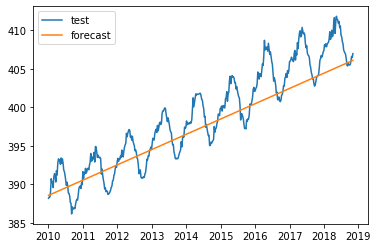

In [313]:
#plt.plot(train.date, train.ppm_fixed, label='train');
plt.plot(test.date, test.ppm_fixed, label='test');
plt.plot(test.date, forecast.yhat, label='forecast');
plt.legend();

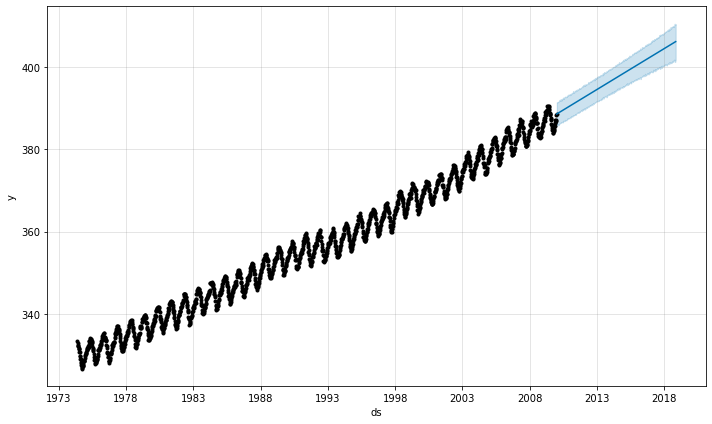

In [314]:
model.plot(forecast);

### Adding seasonality

In [315]:
model_season_y = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

In [316]:
model_season_y.fit(fb_df)

In [317]:
future_season_y = model_season_y.make_future_dataframe(periods=len(test), freq='W', include_history=False)

In [318]:
forecast_season_y = model_season_y.predict(future_season_y)

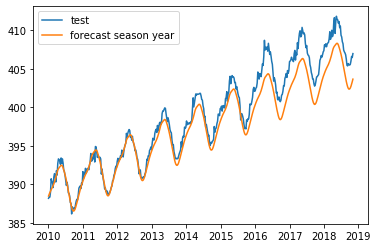

In [319]:
#plt.plot(train.date, train.ppm_fixed, label='train');
plt.plot(test.date, test.ppm_fixed, label='test');
plt.plot(forecast_season_y.ds, forecast_season_y.yhat, label='forecast season year');
plt.legend();

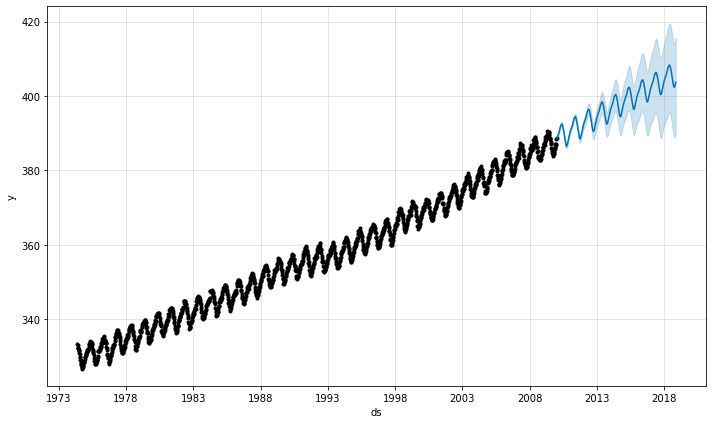

In [320]:
model_season_y.plot(forecast_season_y);

### Linear

In [321]:
def linear_func(ppm_fixed, k=None, b=0):
    mean_value = np.mean(ppm_fixed)
    if k is None:
        return [mean_value] * len(ppm_fixed)
    
    return [idx*k + b for idx, _ in enumerate(ppm_fixed)]

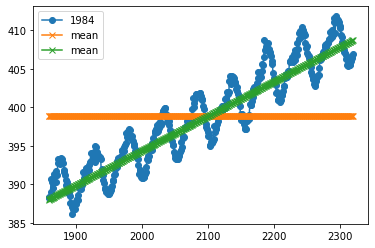

In [322]:
k = 0.045
b = 388

plt.plot(test.index, test.ppm_fixed, 'o-', label=year)
plt.plot(test.index, linear_func(test.ppm_fixed), 'x-', label='mean');
plt.plot(test.index, linear_func(test.ppm_fixed, k, b), 'x-', label='mean');

plt.legend();

### Graphs:

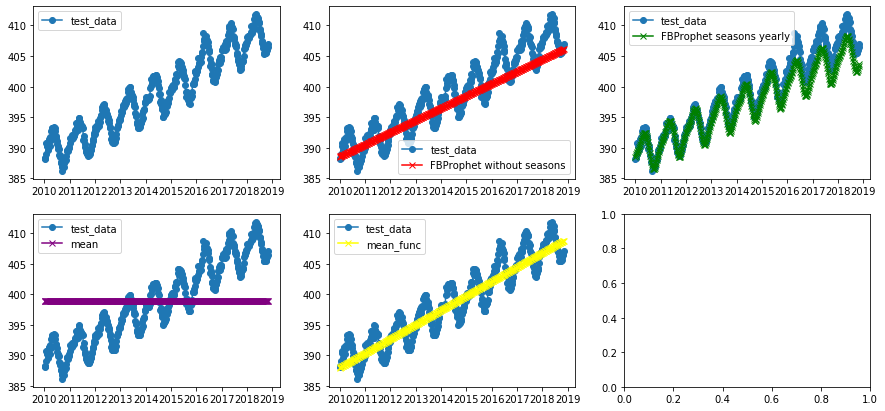

In [323]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))
ax1.plot(test.date, test.ppm_fixed, 'o-', label='test_data')
ax1.legend();

ax2.plot(test.date, test.ppm_fixed, 'o-', label='test_data')
ax2.plot(forecast.ds, forecast.yhat, 'x-', label='FBProphet without seasons', color='red');
ax2.legend();

ax3.plot(test.date, test.ppm_fixed, 'o-', label='test_data')
ax3.plot(forecast_season_y.ds, forecast_season_y.yhat, 'x-', label='FBProphet seasons yearly', color='green');
ax3.legend();

ax4.plot(test.date, test.ppm_fixed, 'o-', label='test_data')
ax4.plot(test.date, linear_func(test.ppm_fixed), 'x-', label='mean', color='purple');
ax4.legend();

ax5.plot(test.date, test.ppm_fixed, 'o-', label='test_data')
ax5.plot(test.date, linear_func(test.ppm_fixed, k, b), 'x-', label='mean_func', color='yellow');
ax5.legend();

### Evaluation

In [324]:
print('Cut year: ', cut_year)
print('Prophet MAE without seasons: ', np.round(mae(test.ppm_fixed, forecast.yhat), 4))
print('Prophet MAE seasons yearly: ', np.round(mae(test.ppm_fixed, forecast_season_y.yhat), 4))
print('For test data range with k: ', k, ' and b: ', b)
print('MAE mean: ', np.round(mae(test.ppm_fixed, linear_func(test.ppm_fixed)), 4))
print('MAE linear: ', np.round(mae(test.ppm_fixed, linear_func(test.ppm_fixed, k, b)), 4))

Cut year:  2010
Prophet MAE without seasons:  2.4103
Prophet MAE seasons yearly:  1.4686
For test data range with k:  0.045  and b:  388
MAE mean:  5.545
MAE linear:  2.039
